In [1]:
import pickle
import gzip
import numpy as np
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split 
from sklearn import metrics 
# import bentoml

### Data Loading

In [2]:
f = gzip.open('mnist/DeepLearningPython/mnist.pkl.gz', 'rb')
training_data, validation_data, test_data = pickle.load(f, encoding="latin1")
f.close()

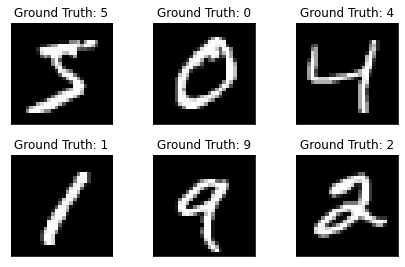

In [3]:
fig = plt.figure()
for i in range(6):
    t = training_data[0][i]
    t = t.reshape(-1, 28)
    
    
    plt.subplot(2, 3, i+1)
    plt.tight_layout()
    plt.imshow(t, cmap="gray", interpolation='none')
    plt.title(f"Ground Truth: {training_data[1][i]}")
    plt.xticks([])
    plt.yticks([])

### SVM for Baseline on MNIST Data

In [4]:
clf = svm.SVC()
clf.fit(training_data[0], training_data[1])

SVC()

In [5]:
preds = [int(a) for a in clf.predict(test_data[0])]
num_correct = sum(int(a==y) for a, y in zip(preds, test_data[1]))
print("Baseline classifier using an SVM.")
print(str(num_correct) + " of " + str(len(test_data[1])) + " values correct.")
print(f"Accuracy: {num_correct/len(test_data[1])}")

Baseline classifier using an SVM.
9785 of 10000 values correct.
Accuracy: 0.9785


In [6]:
clf = DecisionTreeClassifier(criterion="entropy", max_depth=100)
clf.fit(training_data[0], training_data[1])

DecisionTreeClassifier(criterion='entropy', max_depth=100)

In [7]:
preds = [int(a) for a in clf.predict(test_data[0])]
num_correct = sum(int(a==y) for a, y in zip(preds, test_data[1]))
print("Baseline classifier using a Decision Tree.")
print(str(num_correct) + " of " + str(len(test_data[1])) + " values correct.")
print(f"Accuracy: {num_correct/len(test_data[1])}")

Baseline classifier using a Decision Tree.
8827 of 10000 values correct.
Accuracy: 0.8827


### Network

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import tensor
from torch.utils.data import TensorDataset, DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize

/opt/miniconda3/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (5.1.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [9]:
# train_loader = DataLoader(
#   MNIST('./files/', train=True, download=True,
#                              transform=Compose([
#                                ToTensor(),
#                                Normalize(
#                                  (0.1307,), (0.3081,))
#                              ])),
#   batch_size=batch_size_train, shuffle=True)

# test_loader = DataLoader(
#   MNIST('./files/', train=False, download=True,
#                              transform=Compose([
#                                ToTensor(),
#                                Normalize(
#                                  (0.1307,), (0.3081,))
#                              ])),
#   batch_size=batch_size_test, shuffle=True)

In [10]:
# print(len(train_loader))
# print(len(train_loader.dataset))

#### Model

In [11]:
n_epochs = 40
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.008
momentum = 0.5
log_interval = 100

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [12]:
f = gzip.open('mnist/DeepLearningPython/mnist.pkl.gz', 'rb')
training_data, validation_data, test_data = pickle.load(f, encoding="latin1")
f.close()

In [13]:
train_2d = [im.reshape(-1, 28) for im in training_data[0]]
test_2d = [im.reshape(-1, 28) for im in test_data[0]]
valid_2d = [im.reshape(-1, 28) for im in validation_data[0]]

training_data = TensorDataset(tensor(train_2d), tensor(training_data[1]))
train_loader = DataLoader(training_data, batch_size=batch_size_train, shuffle=True)
test_data = TensorDataset(tensor(test_2d), tensor(test_data[1]))
test_loader = DataLoader(test_data, batch_size=batch_size_test, shuffle=True)
# validation_data = TensorDataset(tensor(valid_2d), tensor(validation_data[1]))
# validation_loader = DataLoader(validation_data)

<ipython-input-13-5f158124eb9d>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1682343686209/work/torch/csrc/utils/tensor_new.cpp:248.)
  training_data = TensorDataset(tensor(train_2d), tensor(training_data[1]))


In [14]:
len(train_2d)

50000

In [15]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        # x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)


In [16]:
network = Network()
optimizer = optim.SGD(network.parameters(), lr=learning_rate)

#### Training

In [17]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs+1)]

def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.reshape(-1, 1, 28, 28)
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(train_loader.dataset),100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), './results/model.pth')
            torch.save(optimizer.state_dict(), './results/optimizer.pth')
            

In [18]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.reshape(-1, 1, 28, 28)
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print(f'\nTest set: Avg. loss: {test_loss}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset)}%)\n')

In [19]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

<ipython-input-15-2b8acc169c88>:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
/opt/miniconda3/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.312046240234375, Accuracy: 1135/10000 (11.350000381469727%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.331249
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.306489
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.279971
Train Epoch: 1 [19200/50000 (38%)]	Loss: 2.239891
Train Epoch: 1 [25600/50000 (51%)]	Loss: 2.212568
Train Epoch: 1 [32000/50000 (64%)]	Loss: 2.075649
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.809108
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.447141

Test set: Avg. loss: 1.10734013671875, Accuracy: 7222/10000 (72.22000122070312%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.371964
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.210988
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.079984
Train Epoch: 2 [19200/50000 (38%)]	Loss: 0.762920
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.923408
Train Epoch: 2 [32000/50000 (64%)]	Loss: 0.523650
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.758313
Train Epoch: 2 [44800/50000 (90%)]	Loss: 0.640798

Test set: Avg. loss: 0.41659173583984377, A

Text(0, 0.5, 'negative log likelihood loss')

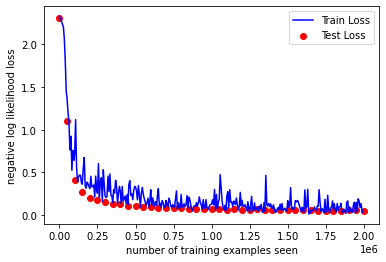

In [20]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

In [21]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
ex = example_data.reshape(-1, 1, 28, 28)

In [27]:
with torch.no_grad():
    
    output = network(ex)

<ipython-input-15-2b8acc169c88>:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [36]:
ex[0].shape

torch.Size([1, 28, 28])

In [37]:
output = network(ex[0])
output

<ipython-input-15-2b8acc169c88>:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


tensor([[-1.3528e+01, -1.0613e+01, -1.6051e+01, -2.1122e+01, -1.1946e+01,
         -1.0950e+01, -8.8710e+00, -1.6187e+01, -1.9060e-04, -1.6488e+01]],
       grad_fn=<LogSoftmaxBackward0>)

In [38]:
type(output)

torch.Tensor

In [31]:
output.data.max(1, keepdim=True)[1].item()

8

In [26]:
example_targets[0]

tensor(8)

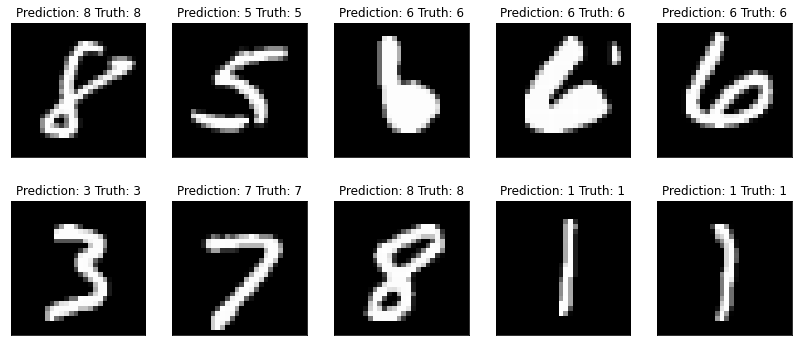

In [23]:
fig = plt.figure(figsize=(14, 6))
for i in range(10):
    plt.subplot(2,5,i+1)
    #plt.tight_layout()
    plt.imshow(example_data[i], cmap='gray', interpolation='none')
    plt.title("Prediction: {} Truth: {}".format(output.data.max(1, keepdim=True)[1][i].item(), example_targets[i]))
    plt.xticks([])
    plt.yticks([])